In [73]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, \
    AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [ ]:
#sharper plots
%config InlineBackend.figure_format = 'retina'

In [2]:
train_data_path = os.getcwd() + '/data/' + "train2016.csv"
test_data_path = os.getcwd() + '/data/' + "test2016.csv"

In [3]:
train = pd.read_csv(train_data_path, index_col='USER_ID')

X_full = train.drop('Party', axis=1)

y_full = train.pop('Party')
y_full = y_full.reset_index(drop=True)

X_test = pd.read_csv(test_data_path, index_col='USER_ID')

In [4]:
X_train, X_test_from_train, y_train, y_test_from_train = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=42,
)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.1,
    random_state=42,
)

In [6]:
X_datasets = [X_train, X_test_from_train, X_val, X_test, X_full]
y_datasets = [y_train, y_test_from_train, y_val, y_full]

In [7]:
display(X_train)

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Q124742,Q124122,Q123464,Q123621,Q122769,...,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024
USER_ID,,,,,,,,,,,,,,,,,,,,,
2282,1962.0,Female,"$25,001 - $50,000",Single (no kids),Bachelor's Degree,NaN,No,No,Yes,Yes,...,Yes,Yes,Yes,Yes,Yes,No,Yes,No,Yes,Yes
5435,1990.0,Male,"over $150,000",Domestic Partners (w/kids),Doctoral Degree,NaN,NaN,No,NaN,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
472,1960.0,Male,"over $150,000",Married (no kids),NaN,NaN,NaN,No,Yes,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3509,1993.0,Male,"under $25,000",Single (no kids),Current Undergraduate,NaN,NaN,NaN,NaN,NaN,...,Yes,NaN,No,NaN,Yes,Yes,NaN,NaN,No,NaN
6014,NaN,Female,NaN,Married (no kids),Bachelor's Degree,Yes,Yes,No,Yes,Yes,...,Yes,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3184,1997.0,Male,NaN,NaN,NaN,Yes,Yes,No,No,No,...,No,No,No,Yes,No,No,Yes,Yes,No,Yes
1404,1990.0,Male,"$25,001 - $50,000",Single (no kids),High School Diploma,Yes,Yes,Yes,No,Yes,...,Yes,Yes,No,Yes,Yes,No,Only-child,No,No,Yes
2665,1988.0,Female,"over $150,000",Single (no kids),Master's Degree,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
display(X_test_from_train)

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Q124742,Q124122,Q123464,Q123621,Q122769,...,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024
USER_ID,,,,,,,,,,,,,,,,,,,,,
1445,1981.0,Male,"$25,001 - $50,000",Married (w/kids),High School Diploma,NaN,Yes,Yes,Yes,No,...,Yes,No,No,Yes,Yes,No,Yes,No,No,Yes
946,1990.0,Male,"under $25,000",Single (no kids),Bachelor's Degree,NaN,No,No,NaN,No,...,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes
588,1990.0,Female,"under $25,000",Single (no kids),Bachelor's Degree,No,No,No,No,No,...,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No
1385,1999.0,Male,NaN,NaN,Current K-12,NaN,Yes,No,NaN,No,...,Yes,No,No,Yes,No,Yes,Yes,No,No,Yes
6713,1990.0,Female,NaN,Single (no kids),High School Diploma,Yes,No,No,Yes,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5361,1997.0,Male,NaN,Single (no kids),Current K-12,Yes,Yes,No,No,No,...,Yes,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes
2610,1997.0,Male,"$50,000 - $74,999",Single (no kids),Current K-12,No,No,No,No,Yes,...,Yes,No,No,Yes,Yes,Yes,Yes,No,Yes,No
6138,NaN,Female,NaN,Married (w/kids),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
display(X_val)

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Q124742,Q124122,Q123464,Q123621,Q122769,...,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024
USER_ID,,,,,,,,,,,,,,,,,,,,,
19,1996.0,Male,"$75,000 - $100,000",Single (no kids),Current K-12,Yes,No,No,No,No,...,No,No,No,Yes,No,Yes,Yes,No,No,Yes
3603,1963.0,Female,"over $150,000",Married (no kids),Bachelor's Degree,NaN,No,No,Yes,Yes,...,Yes,No,No,Yes,NaN,No,Yes,Yes,No,No
2059,1981.0,Male,"$100,001 - $150,000",Married (w/kids),Doctoral Degree,NaN,NaN,NaN,NaN,NaN,...,Yes,No,No,Yes,Yes,No,Yes,Yes,Yes,Yes
4688,1977.0,Female,"over $150,000",Married (w/kids),Bachelor's Degree,Yes,Yes,No,No,Yes,...,Yes,No,Yes,Yes,Yes,No,Yes,Yes,Yes,No
5153,1977.0,Female,"$25,001 - $50,000",Married (w/kids),Current Undergraduate,NaN,NaN,NaN,NaN,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3478,1994.0,Male,"$75,000 - $100,000",Single (no kids),Current Undergraduate,NaN,Yes,Yes,No,No,...,No,No,No,No,Yes,No,Yes,No,No,Yes
2287,1985.0,Female,"under $25,000",Single (no kids),Current Undergraduate,Yes,Yes,Yes,Yes,No,...,Yes,No,No,Yes,Yes,No,Yes,Yes,No,No
461,1996.0,Male,"under $25,000",Single (no kids),Current K-12,No,No,No,No,Yes,...,Yes,No,Yes,No,Yes,Yes,Yes,No,No,Yes


In [10]:
display(X_test)

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Q124742,Q124122,Q123464,Q123621,Q122769,...,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024
USER_ID,,,,,,,,,,,,,,,,,,,,,
2,1985.0,Female,"$25,001 - $50,000",Single (no kids),Master's Degree,NaN,Yes,No,Yes,No,...,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN
3,1983.0,Male,"$50,000 - $74,999",Married (w/kids),Current Undergraduate,NaN,NaN,No,NaN,Yes,...,NaN,NaN,NaN,NaN,Yes,NaN,Yes,Yes,No,Yes
6,1995.0,Male,"$75,000 - $100,000",Single (no kids),Current K-12,NaN,NaN,NaN,NaN,NaN,...,No,No,No,Yes,Yes,No,Yes,No,Yes,Yes
7,1980.0,Female,"$50,000 - $74,999",Single (no kids),Master's Degree,Yes,Yes,No,Yes,Yes,...,Yes,No,No,No,Yes,No,Yes,No,No,Yes
14,1980.0,Female,NaN,Married (no kids),Current Undergraduate,NaN,Yes,No,Yes,No,...,Yes,No,No,Yes,No,No,Yes,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6928,1977.0,Female,"$50,000 - $74,999",Domestic Partners (no kids),Master's Degree,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6930,1998.0,Female,"$100,001 - $150,000",Single (no kids),Current K-12,NaN,NaN,NaN,NaN,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6941,1989.0,Male,"$25,001 - $50,000",Married (no kids),Bachelor's Degree,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
display(X_full)

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Q124742,Q124122,Q123464,Q123621,Q122769,...,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024
USER_ID,,,,,,,,,,,,,,,,,,,,,
1,1938.0,Male,NaN,Married (w/kids),NaN,No,NaN,No,No,No,...,Yes,No,No,NaN,No,NaN,Only-child,No,No,Yes
4,1970.0,Female,"over $150,000",Domestic Partners (w/kids),Bachelor's Degree,NaN,Yes,No,No,No,...,NaN,NaN,NaN,No,No,No,Only-child,Yes,No,No
5,1997.0,Male,"$75,000 - $100,000",Single (no kids),High School Diploma,NaN,Yes,Yes,No,NaN,...,Yes,No,No,No,Yes,No,Yes,No,Yes,No
8,1983.0,Male,"$100,001 - $150,000",Married (w/kids),Bachelor's Degree,No,Yes,No,Yes,No,...,No,No,No,Yes,Yes,No,Yes,No,No,Yes
9,1984.0,Female,"$50,000 - $74,999",Married (w/kids),High School Diploma,No,Yes,No,No,No,...,Yes,No,No,Yes,No,No,Yes,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6956,NaN,Male,NaN,NaN,Master's Degree,NaN,No,No,NaN,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6957,2000.0,Female,NaN,NaN,Current K-12,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6958,1969.0,Male,"over $150,000",NaN,Bachelor's Degree,NaN,NaN,NaN,Yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
display(y_train)

1842      Democrat
4352      Democrat
378       Democrat
2822      Democrat
4818    Republican
           ...    
2558    Republican
1135      Democrat
2139    Republican
1823    Republican
2915    Republican
Name: Party, Length: 4008, dtype: object

In [13]:
X_train.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4008 entries, 2282 to 3629
Columns: 106 entries, YOB to Q96024
dtypes: float64(1), object(105)
memory usage: 3.3+ MB


In [14]:
X_test_from_train.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1114 entries, 1445 to 5564
Columns: 106 entries, YOB to Q96024
dtypes: float64(1), object(105)
memory usage: 931.2+ KB


In [15]:
X_val.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446 entries, 19 to 670
Columns: 106 entries, YOB to Q96024
dtypes: float64(1), object(105)
memory usage: 372.8+ KB


In [16]:
X_test.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1392 entries, 2 to 6947
Columns: 106 entries, YOB to Q96024
dtypes: float64(1), object(105)
memory usage: 1.1+ MB


In [17]:
X_full.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5568 entries, 1 to 6960
Columns: 106 entries, YOB to Q96024
dtypes: float64(1), object(105)
memory usage: 4.5+ MB


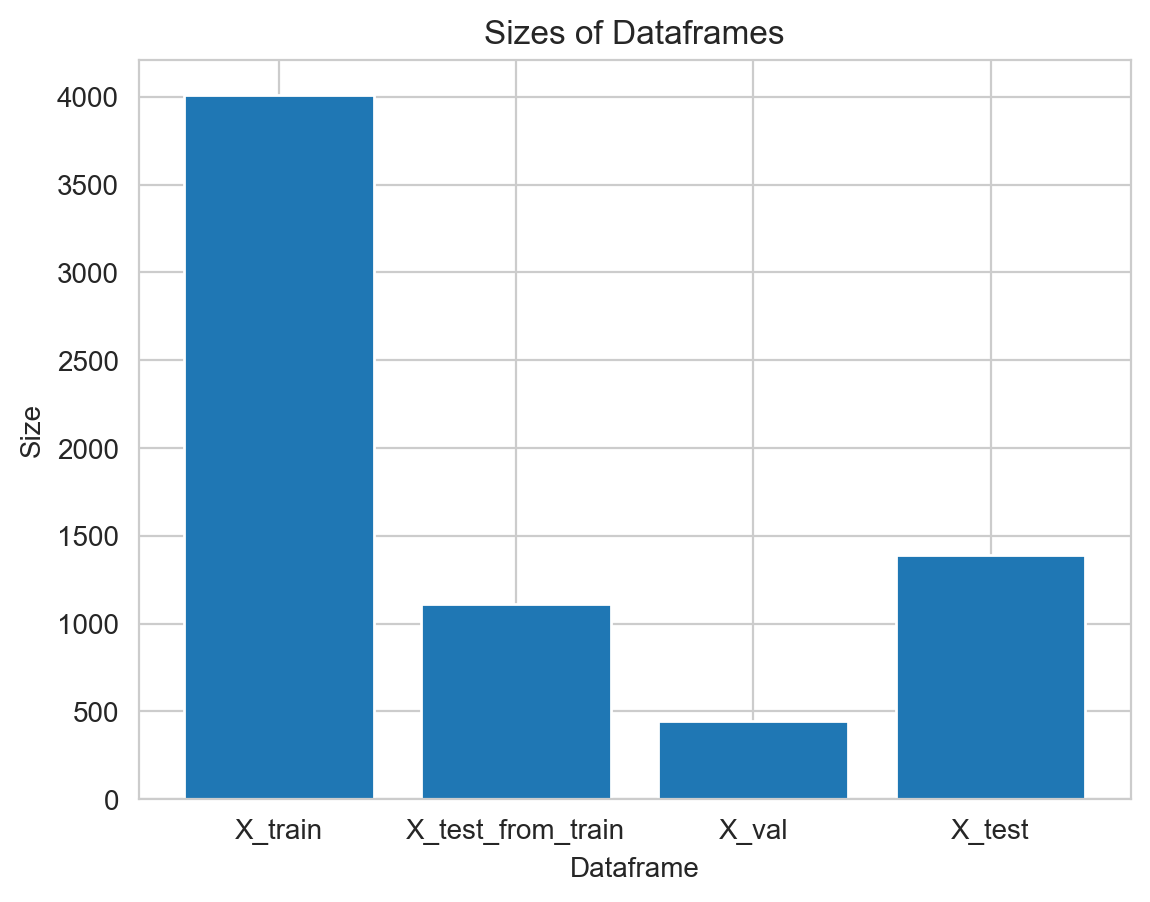

In [18]:
sizes = [X_train.shape[0], X_test_from_train.shape[0], X_val.shape[0], X_test.shape[0]]
labels = ['X_train', 'X_test_from_train', 'X_val', 'X_test']

plt.bar(labels, sizes)
plt.xlabel('Dataframe')
plt.ylabel('Size')
plt.title('Sizes of Dataframes')
plt.rcParams["figure.figsize"] = (25,6)
plt.show()

Move target to the end for visibility purposes.

In [19]:
# for y_dataset in y_datasets:
#     y_dataset = train_df.pop("Party")
#     y_dataset = y_dataset.reset_index(drop=True)

In [20]:
# Perform label encoding on train
le = LabelEncoder()

encoded_y_train = le.fit_transform(y_train)
encoded_y_test_from_train = le.fit_transform(y_test_from_train)
encoded_y_val = le.fit_transform(y_val)
encoded_y_full = le.fit_transform(y_full)

# Get the encoding values dictionary
encoding_dict = {category: encoding for encoding, category in enumerate(le.classes_)}
print(encoding_dict)

{'Democrat': 0, 'Republican': 1}


We can see that some users seems to have only few answers.
Let's check if there is users with no answers at all.

In [21]:
answers_X_train = X_train.iloc[:, 5:-1].copy()
answers_X_test_from_train = X_test_from_train.iloc[:, 5:-1].copy()
answers_X_val = X_val.iloc[:, 5:-1].copy()
answers_X_test = X_test.iloc[:, 5:-1].copy()
answers_X_full = X_full.iloc[:, 5:-1].copy()

Check if questions in test and train are the same.

In [22]:
train_answers_columns = set(answers_X_train.columns)
test_answers_columns = set(answers_X_test.columns)

# Check if the column sets are the same
if train_answers_columns == test_answers_columns:
    print("The columns in train and test datasets are the same.")
else:
    print("The columns in train and test datasets are different.")

The columns in train and test datasets are the same.


In [23]:
def get_nan_rows(df):
    nan = df[df.isnull().all(axis=1)].index
    return nan

In [24]:
display(get_nan_rows(answers_X_train))
display(get_nan_rows(answers_X_test_from_train))
display(get_nan_rows(answers_X_val))
display(get_nan_rows(answers_X_test))
display(get_nan_rows(answers_X_full))

Int64Index([5942, 6220, 6226, 6223, 5250, 3350, 6647], dtype='int64', name='USER_ID')

Int64Index([3926, 5830], dtype='int64', name='USER_ID')

Int64Index([2288, 3894], dtype='int64', name='USER_ID')

Int64Index([1936, 3170, 3703, 3762, 3781, 4079, 5130, 5254, 6807], dtype='int64', name='USER_ID')

Int64Index([2288, 3350, 3894, 3926, 5250, 5830, 5942, 6220, 6223, 6226, 6647], dtype='int64', name='USER_ID')

As we can see, some users left all questions without answers.
Not sure, if this data is informative.
Sometimes the absence of an answer is the answer.

In [25]:
# Add NaNCount feature that shows number of non-answered questions for a single person.
X_train['NaNCount'] = X_train.isnull().sum(axis=1)
X_test_from_train['NaNCount'] = X_test_from_train.isnull().sum(axis=1)
X_val['NaNCount'] = X_val.isnull().sum(axis=1)
X_test['NaNCount'] = X_test.isnull().sum(axis=1)
X_full['NaNCount'] = X_full.isnull().sum(axis=1)

X_train['NaNCount'].head()

USER_ID
2282     3
5435    63
472     49
3509    79
6014    14
Name: NaNCount, dtype: int64

# Fill NaNs

In [26]:
for X_dataset in X_datasets:
    mean_year_of_birth = X_dataset['YOB'].mean()
    X_dataset['YOB'].fillna(mean_year_of_birth, inplace=True)

In [27]:
columns_to_encode = X_train.columns[1:X_train.shape[0]].to_list()
#columns_to_encode = columns_to_encode.to_list()
columns_to_encode.remove('NaNCount')
print(columns_to_encode)

['Gender', 'Income', 'HouseholdStatus', 'EducationLevel', 'Q124742', 'Q124122', 'Q123464', 'Q123621', 'Q122769', 'Q122770', 'Q122771', 'Q122120', 'Q121699', 'Q121700', 'Q120978', 'Q121011', 'Q120379', 'Q120650', 'Q120472', 'Q120194', 'Q120012', 'Q120014', 'Q119334', 'Q119851', 'Q119650', 'Q118892', 'Q118117', 'Q118232', 'Q118233', 'Q118237', 'Q117186', 'Q117193', 'Q116797', 'Q116881', 'Q116953', 'Q116601', 'Q116441', 'Q116448', 'Q116197', 'Q115602', 'Q115777', 'Q115610', 'Q115611', 'Q115899', 'Q115390', 'Q114961', 'Q114748', 'Q115195', 'Q114517', 'Q114386', 'Q113992', 'Q114152', 'Q113583', 'Q113584', 'Q113181', 'Q112478', 'Q112512', 'Q112270', 'Q111848', 'Q111580', 'Q111220', 'Q110740', 'Q109367', 'Q108950', 'Q109244', 'Q108855', 'Q108617', 'Q108856', 'Q108754', 'Q108342', 'Q108343', 'Q107869', 'Q107491', 'Q106993', 'Q106997', 'Q106272', 'Q106388', 'Q106389', 'Q106042', 'Q105840', 'Q105655', 'Q104996', 'Q103293', 'Q102906', 'Q102674', 'Q102687', 'Q102289', 'Q102089', 'Q101162', 'Q10116

In [28]:
onehot_encoder = OneHotEncoder(sparse_output=False)

In [29]:
encoded_matrix_X_train = onehot_encoder.fit_transform(X_train[columns_to_encode])
column_names = onehot_encoder.get_feature_names_out()
encoded_X_train = pd.DataFrame(encoded_matrix_X_train, columns=column_names)

encoded_X_train.index = X_train.index
encoded_X_train = pd.concat([encoded_X_train, X_train['NaNCount'], X_train['YOB']], axis=1)

encoded_X_train.head()

,Gender_Female,Gender_Male,Gender_nan,"Income_$100,001 - $150,000","Income_$25,001 - $50,000","Income_$50,000 - $74,999","Income_$75,000 - $100,000","Income_over $150,000","Income_under $25,000",Income_nan,...,Q98078_Yes,Q98078_nan,Q98197_No,Q98197_Yes,Q98197_nan,Q96024_No,Q96024_Yes,Q96024_nan,NaNCount,YOB
USER_ID,,,,,,,,,,,,,,,,,,,,,
2282,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3,1962.000000
5435,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,63,1990.000000
472,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,49,1960.000000
3509,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,79,1993.000000
6014,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,14,1979.769679


In [30]:
encoded_matrix_X_test_from_train = onehot_encoder.fit_transform(X_test_from_train[columns_to_encode])
encoded_X_test_from_train = pd.DataFrame(encoded_matrix_X_test_from_train, columns=column_names)

encoded_X_test_from_train.index = X_test_from_train.index
encoded_X_test_from_train = pd.concat([encoded_X_test_from_train, X_test_from_train['NaNCount'], X_test_from_train['YOB']], axis=1)


encoded_X_test_from_train.head()

,Gender_Female,Gender_Male,Gender_nan,"Income_$100,001 - $150,000","Income_$25,001 - $50,000","Income_$50,000 - $74,999","Income_$75,000 - $100,000","Income_over $150,000","Income_under $25,000",Income_nan,...,Q98078_Yes,Q98078_nan,Q98197_No,Q98197_Yes,Q98197_nan,Q96024_No,Q96024_Yes,Q96024_nan,NaNCount,YOB
USER_ID,,,,,,,,,,,,,,,,,,,,,
1445,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1981.0
946,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,34,1990.0
588,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,1990.0
1385,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4,1999.0
6713,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,78,1990.0


In [31]:
encoded_matrix_X_val = onehot_encoder.fit_transform(X_val[columns_to_encode])
encoded_X_val = pd.DataFrame(encoded_matrix_X_val, columns=column_names)

encoded_X_val.index = X_val.index
encoded_X_val = pd.concat([encoded_X_val, X_val['NaNCount'], X_val['YOB']], axis=1)

encoded_X_val.head()

,Gender_Female,Gender_Male,Gender_nan,"Income_$100,001 - $150,000","Income_$25,001 - $50,000","Income_$50,000 - $74,999","Income_$75,000 - $100,000","Income_over $150,000","Income_under $25,000",Income_nan,...,Q98078_Yes,Q98078_nan,Q98197_No,Q98197_Yes,Q98197_nan,Q96024_No,Q96024_Yes,Q96024_nan,NaNCount,YOB
USER_ID,,,,,,,,,,,,,,,,,,,,,
19,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1996.0
3603,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,7,1963.0
2059,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,28,1981.0
4688,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,1977.0
5153,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,57,1977.0


In [32]:
encoded_matrix_X_test = onehot_encoder.fit_transform(X_test[columns_to_encode])
encoded_X_test = pd.DataFrame(encoded_matrix_X_test, columns=column_names)

encoded_X_test.index = X_test.index
encoded_X_test = pd.concat([encoded_X_test, X_test['NaNCount'], X_test['YOB']], axis=1)

encoded_X_test.head()

,Gender_Female,Gender_Male,Gender_nan,"Income_$100,001 - $150,000","Income_$25,001 - $50,000","Income_$50,000 - $74,999","Income_$75,000 - $100,000","Income_over $150,000","Income_under $25,000",Income_nan,...,Q98078_Yes,Q98078_nan,Q98197_No,Q98197_Yes,Q98197_nan,Q96024_No,Q96024_Yes,Q96024_nan,NaNCount,YOB
USER_ID,,,,,,,,,,,,,,,,,,,,,
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,35,1985.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,52,1983.0
6,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,33,1995.0
7,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,1980.0
14,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4,1980.0


In [33]:
encoded_matrix_X_full = onehot_encoder.fit_transform(X_full[columns_to_encode])
encoded_X_full = pd.DataFrame(encoded_matrix_X_full, columns=column_names)

encoded_X_full.index = X_full.index
encoded_X_full = pd.concat([encoded_X_full, X_full['NaNCount'], X_full['YOB']], axis=1)

encoded_X_full.head()

,Gender_Female,Gender_Male,Gender_nan,"Income_$100,001 - $150,000","Income_$25,001 - $50,000","Income_$50,000 - $74,999","Income_$75,000 - $100,000","Income_over $150,000","Income_under $25,000",Income_nan,...,Q98078_Yes,Q98078_nan,Q98197_No,Q98197_Yes,Q98197_nan,Q96024_No,Q96024_Yes,Q96024_nan,NaNCount,YOB
USER_ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,17,1938.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,26,1970.0
5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3,1997.0
8,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,1983.0
9,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,1984.0


In [34]:
# get the column names
column_names = onehot_encoder.get_feature_names_out()
print(column_names)

['Gender_Female' 'Gender_Male' 'Gender_nan' 'Income_$100,001 - $150,000'
 'Income_$25,001 - $50,000' 'Income_$50,000 - $74,999'
 'Income_$75,000 - $100,000' 'Income_over $150,000' 'Income_under $25,000'
 'Income_nan' 'HouseholdStatus_Domestic Partners (no kids)'
 'HouseholdStatus_Domestic Partners (w/kids)'
 'HouseholdStatus_Married (no kids)' 'HouseholdStatus_Married (w/kids)'
 'HouseholdStatus_Single (no kids)' 'HouseholdStatus_Single (w/kids)'
 'HouseholdStatus_nan' "EducationLevel_Associate's Degree"
 "EducationLevel_Bachelor's Degree" 'EducationLevel_Current K-12'
 'EducationLevel_Current Undergraduate' 'EducationLevel_Doctoral Degree'
 'EducationLevel_High School Diploma' "EducationLevel_Master's Degree"
 'EducationLevel_nan' 'Q124742_No' 'Q124742_Yes' 'Q124742_nan'
 'Q124122_No' 'Q124122_Yes' 'Q124122_nan' 'Q123464_No' 'Q123464_Yes'
 'Q123464_nan' 'Q123621_No' 'Q123621_Yes' 'Q123621_nan' 'Q122769_No'
 'Q122769_Yes' 'Q122769_nan' 'Q122770_No' 'Q122770_Yes' 'Q122770_nan'
 'Q122771

In [35]:
# Skip columns with "_nan" suffix
columns_to_skip = encoded_X_train.columns[~encoded_X_train.columns.str.endswith('_nan')]
encoded_X_train_filtered = encoded_X_train[columns_to_skip]

In [36]:
#corr_matrix = encoded_train_df_filtered.corr().abs()
corr_matrix = encoded_X_train_filtered.corr()
#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))

display(sol)

Q99716_No      Q99581_No      0.662387
Q113181_Yes    Q98197_Yes     0.652231
Q113181_No     Q98197_No      0.644039
Q100010_Yes    Q99716_No      0.585573
Q99581_No      Q99480_Yes     0.583428
                                ...   
Q123464_No     NaNCount      -0.660653
Q99581_No      NaNCount      -0.675629
Q98059_Yes     NaNCount      -0.686331
Q99716_No      NaNCount      -0.686738
Gender_Female  Gender_Male   -0.958151
Length: 25200, dtype: float64

In [37]:
# fix lightgbm.basic.LightGBMError: Do not support special JSON characters in feature name.
encoded_X_datasets = [encoded_X_train, encoded_X_test_from_train, encoded_X_val, encoded_X_test, encoded_X_full]

# encoded_X_datasets = [encoded_X_train, encoded_X_test_from_train, encoded_X_val, encoded_X_test]
# for encoded_X_dataset in encoded_X_datasets:
#     encoded_X_dataset.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace=True)

encoded_X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace=True)
encoded_X_test_from_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace=True)
encoded_X_val.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace=True)
encoded_X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace=True)
encoded_X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace=True)
encoded_X_full.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace=True)

In [38]:
# drop Gender_Female feature (-0.958 correlation with Gender_Male)
# drop USER_ID feature
for encoded_X_dataset in encoded_X_datasets:
    encoded_X_dataset.drop('Gender_Female', axis=1)

In [39]:
encoded_X_train.head(150)

,Gender_Female,Gender_Male,Gender_nan,Income_100001150000,Income_2500150000,Income_5000074999,Income_75000100000,Income_over150000,Income_under25000,Income_nan,...,Q98078_Yes,Q98078_nan,Q98197_No,Q98197_Yes,Q98197_nan,Q96024_No,Q96024_Yes,Q96024_nan,NaNCount,YOB
USER_ID,,,,,,,,,,,,,,,,,,,,,
2282,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3,1962.000000
5435,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,63,1990.000000
472,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,49,1960.000000
3509,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,79,1993.000000
6014,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,14,1979.769679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,62,1997.000000
1249,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,15,1979.000000
2996,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,23,1944.000000


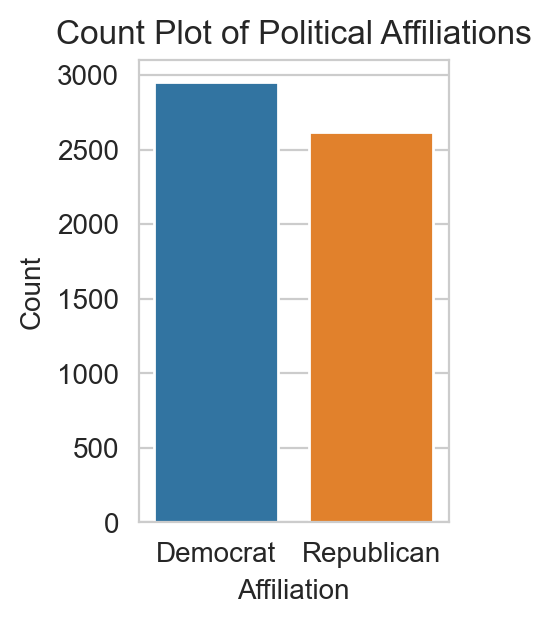

In [40]:
# Check target balance
plt.figure(figsize=(2, 3))
sns.countplot(x=y_full)
plt.title("Count Plot of Political Affiliations")
plt.xlabel("Affiliation")
plt.ylabel("Count")
plt.show()

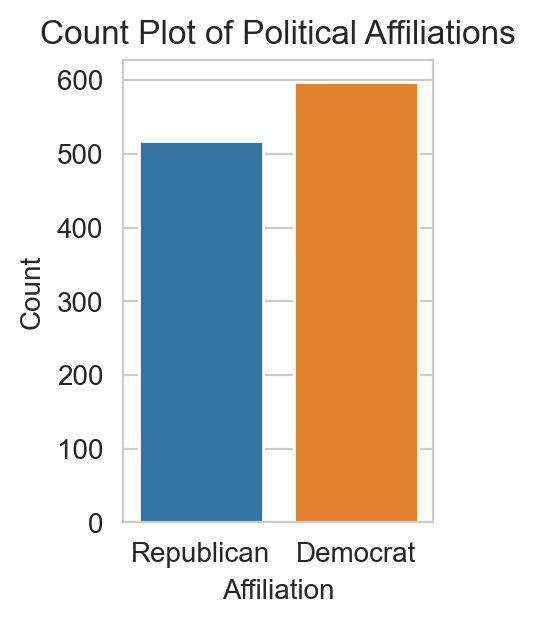

In [41]:
encoded_X_train.head(150)
# Check target balance
plt.figure(figsize=(2, 3))
sns.countplot(x=y_test_from_train)
plt.title("Count Plot of Political Affiliations")
plt.xlabel("Affiliation")
plt.ylabel("Count")
plt.show()

# Modeling differents algorithms

In [42]:
random_state = 2
#kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=random_state)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

In [43]:
classifiers = []
#classifiers.append(SVC(random_state=random_state, probability=True))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(XGBClassifier(seed=random_state))
classifiers.append(LGBMClassifier(seed=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

In [44]:
%%time
cv_results = []
for index, classifier in enumerate(classifiers):
    cv_results.append(cross_val_score(classifier, encoded_X_train, y = encoded_y_train, scoring = "roc_auc", cv = kfold, n_jobs=-1, verbose=3))
    print(f"Progress: {index + 1}/{len(classifiers)} done!")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Progress: 1/11 done!


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Progress: 2/11 done!


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Progress: 3/11 done!


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Progress: 4/11 done!


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.4s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Progress: 5/11 done!


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.3s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Progress: 6/11 done!


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Progress: 7/11 done!


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Progress: 8/11 done!


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Progress: 9/11 done!


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Progress: 10/11 done!


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s


Progress: 11/11 done!
CPU times: total: 297 ms
Wall time: 41.3 s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [45]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

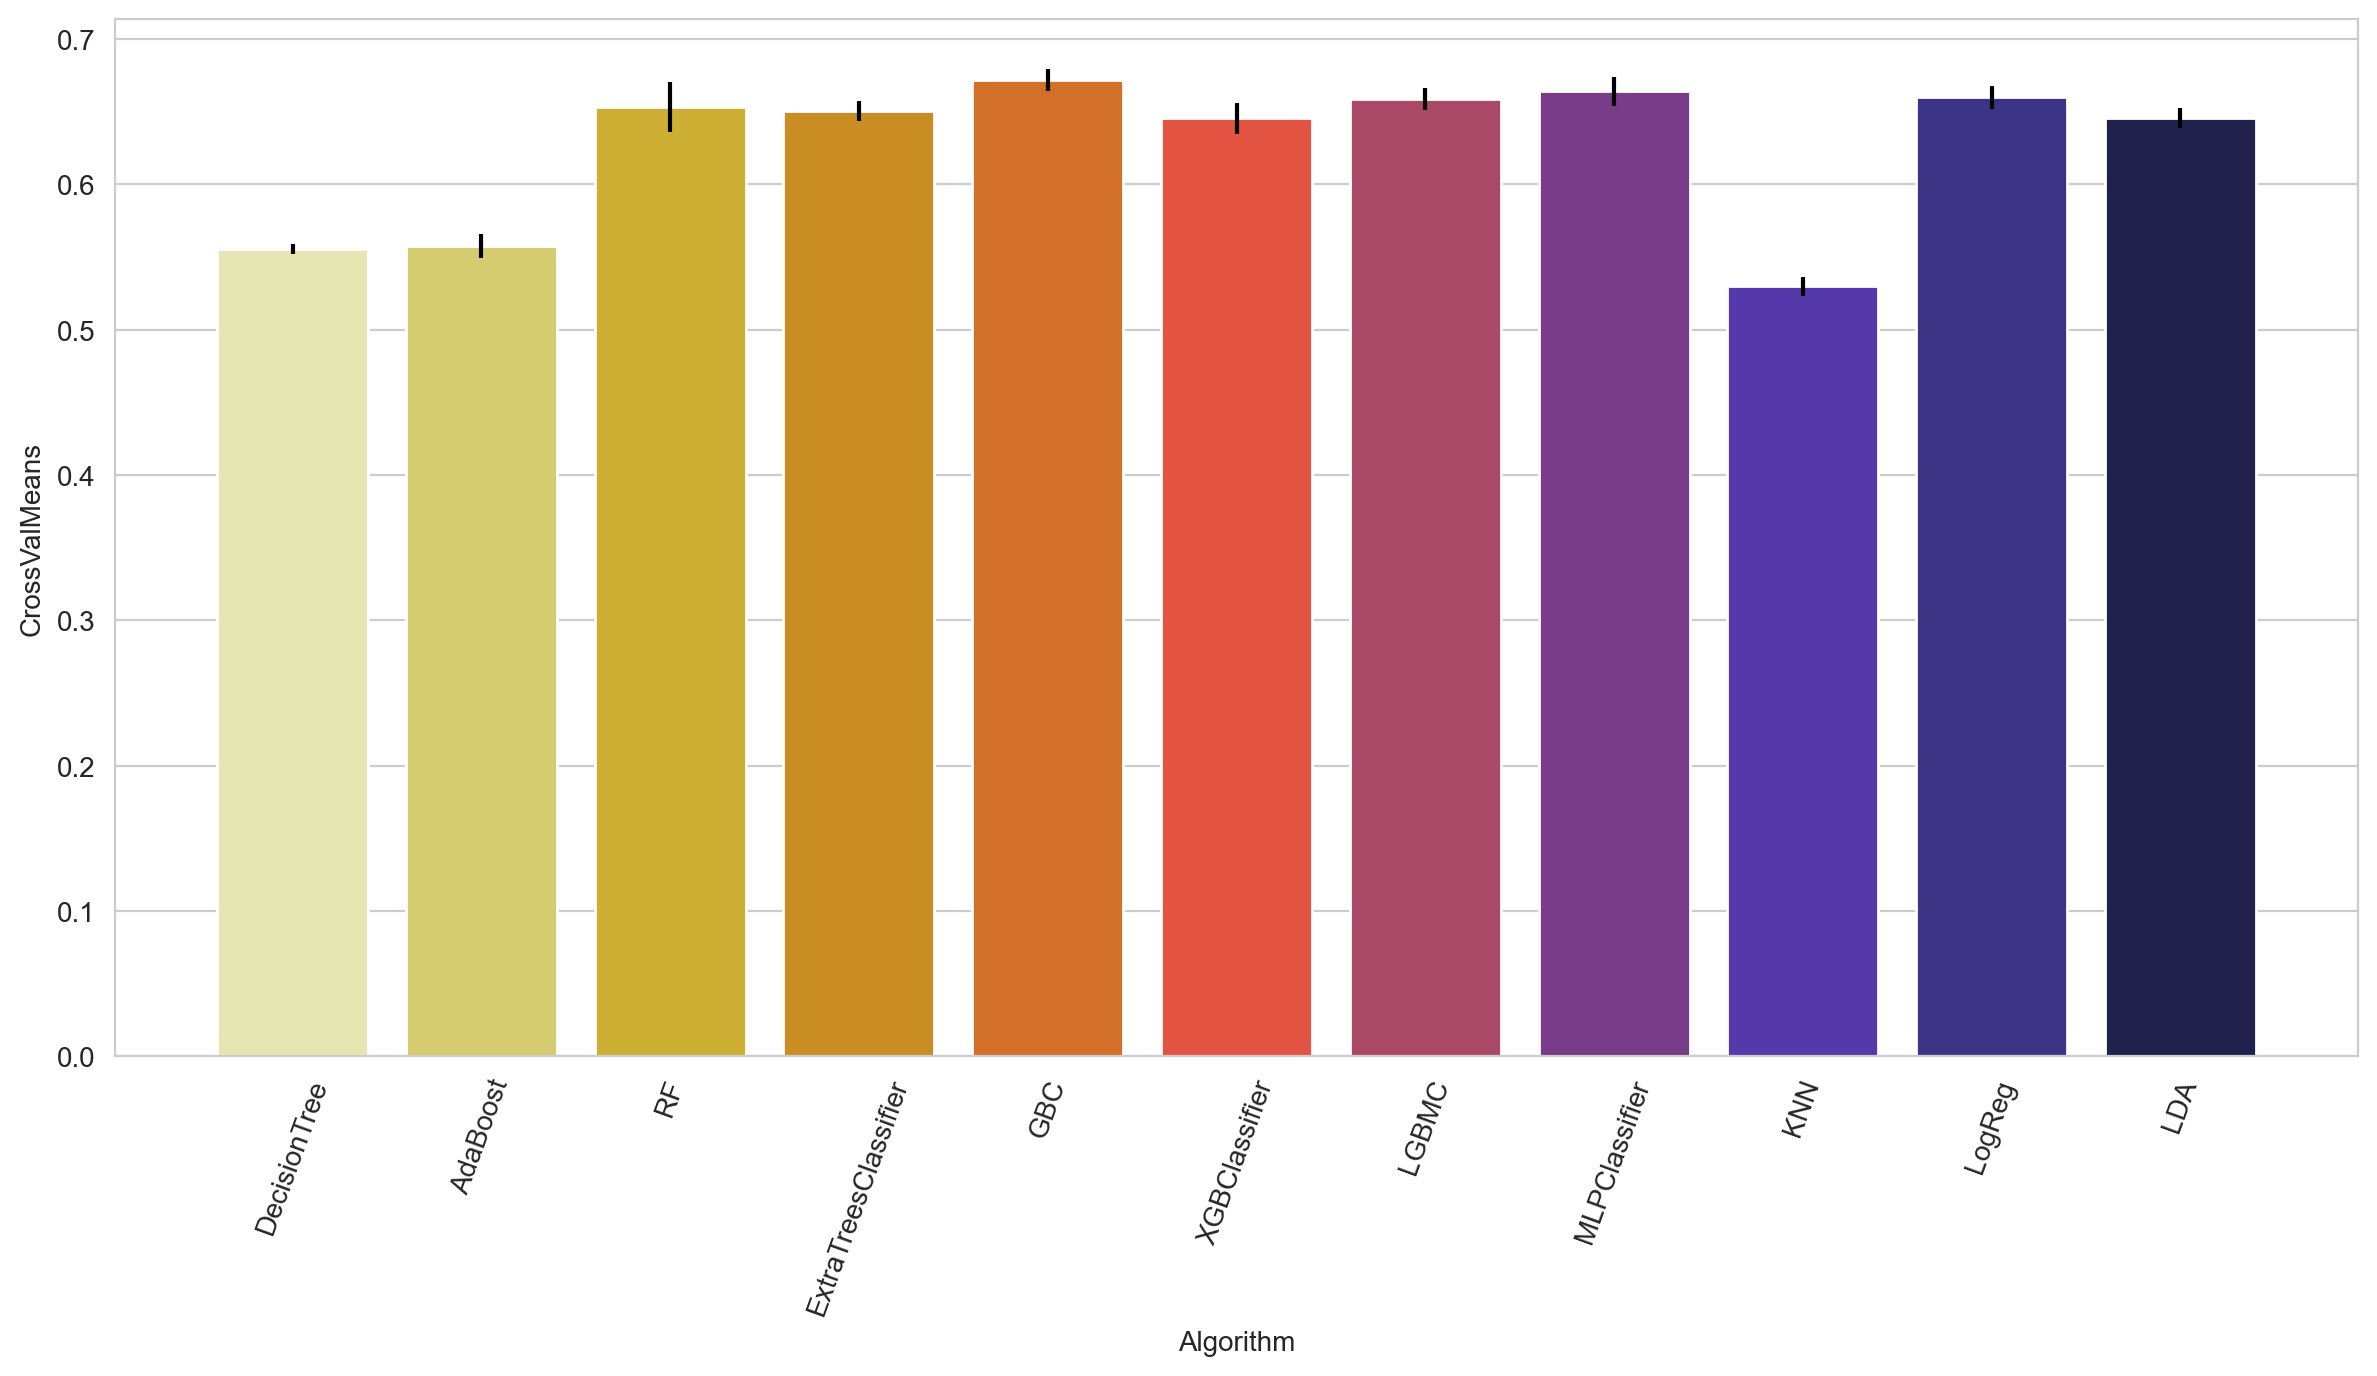

In [46]:
cv_res = pd.DataFrame(
    {"CrossValMeans": cv_means,
     "CrossValerrors": cv_std,
     "Algorithm": [#"SVC",
                    "DecisionTree",
                    "AdaBoost",
                    "RF",
                    "ExtraTreesClassifier",
                    "GBC",
                    "XGBClassifier",
                    "LGBMC",
                    "MLPClassifier",
                    "KNN",
                    "LogReg",
                     "LDA"]})

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='Algorithm', y='CrossValMeans', data=cv_res, palette='CMRmap_r')
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
ax.errorbar(x=x_coords, y=y_coords, yerr=cv_res["CrossValerrors"], fmt="none", c="k")
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

In [47]:
cv_res_sorted = cv_res.sort_values(by='CrossValMeans', ascending=False)
cv_res_sorted.head(15)

,CrossValMeans,CrossValerrors,Algorithm
4,0.672147,0.007551,GBC
7,0.664122,0.009805,MLPClassifier
9,0.660105,0.007929,LogReg
6,0.658998,0.007465,LGBMC
2,0.653255,0.017227,RF
3,0.650480,0.007084,ExtraTreesClassifier
10,0.645537,0.006968,LDA
5,0.645441,0.010628,XGBClassifier
1,0.557844,0.008400,AdaBoost
0,0.555583,0.003588,DecisionTree


In [48]:
algorithm = ["DecisionTree",
             "AdaBoost",
             "RF",
             "ExtraTreesClassifier",
             "GBC",
             "XGBClassifier",
             "LGBMC",
             "MLPClassifier",
             "KNN",
             "LogReg",
             "LDA"]

predictions = {}

# Fit each classifier and make predictions
for algorithm_name, classifier in zip(algorithm, classifiers):
    classifier.fit(encoded_X_train, encoded_y_train)
    predicted_value = classifier.predict_proba(encoded_X_test)[:, 1]
    predictions[algorithm_name] = predicted_value
    print(f"Progress: {algorithm_name} done!")

Progress: DecisionTree done!
Progress: AdaBoost done!
Progress: RF done!
Progress: ExtraTreesClassifier done!
Progress: GBC done!
Progress: XGBClassifier done!
Progress: LGBMC done!
Progress: MLPClassifier done!
Progress: KNN done!
Progress: LogReg done!
Progress: LDA done!


In [49]:
predictions_df = pd.DataFrame(predictions)
print(predictions_df)

      DecisionTree      AdaBoost    RF  ExtraTreesClassifier       GBC  \
0              0.0  2.220446e-16  0.38                  0.40  0.195304   
1              1.0  1.000000e+00  0.48                  0.48  0.665884   
2              0.0  2.220446e-16  0.60                  0.59  0.677843   
3              0.0  2.220446e-16  0.22                  0.14  0.120854   
4              0.0  2.220446e-16  0.46                  0.40  0.411135   
...            ...           ...   ...                   ...       ...   
1387           1.0  1.000000e+00  0.41                  0.49  0.368407   
1388           1.0  2.220446e-16  0.34                  0.33  0.419280   
1389           1.0  1.000000e+00  0.51                  0.63  0.496388   
1390           0.0  2.220446e-16  0.62                  0.53  0.589238   
1391           0.0  1.000000e+00  0.49                  0.40  0.494668   

      XGBClassifier     LGBMC  MLPClassifier  KNN    LogReg       LDA  
0          0.122538  0.113795       0.0

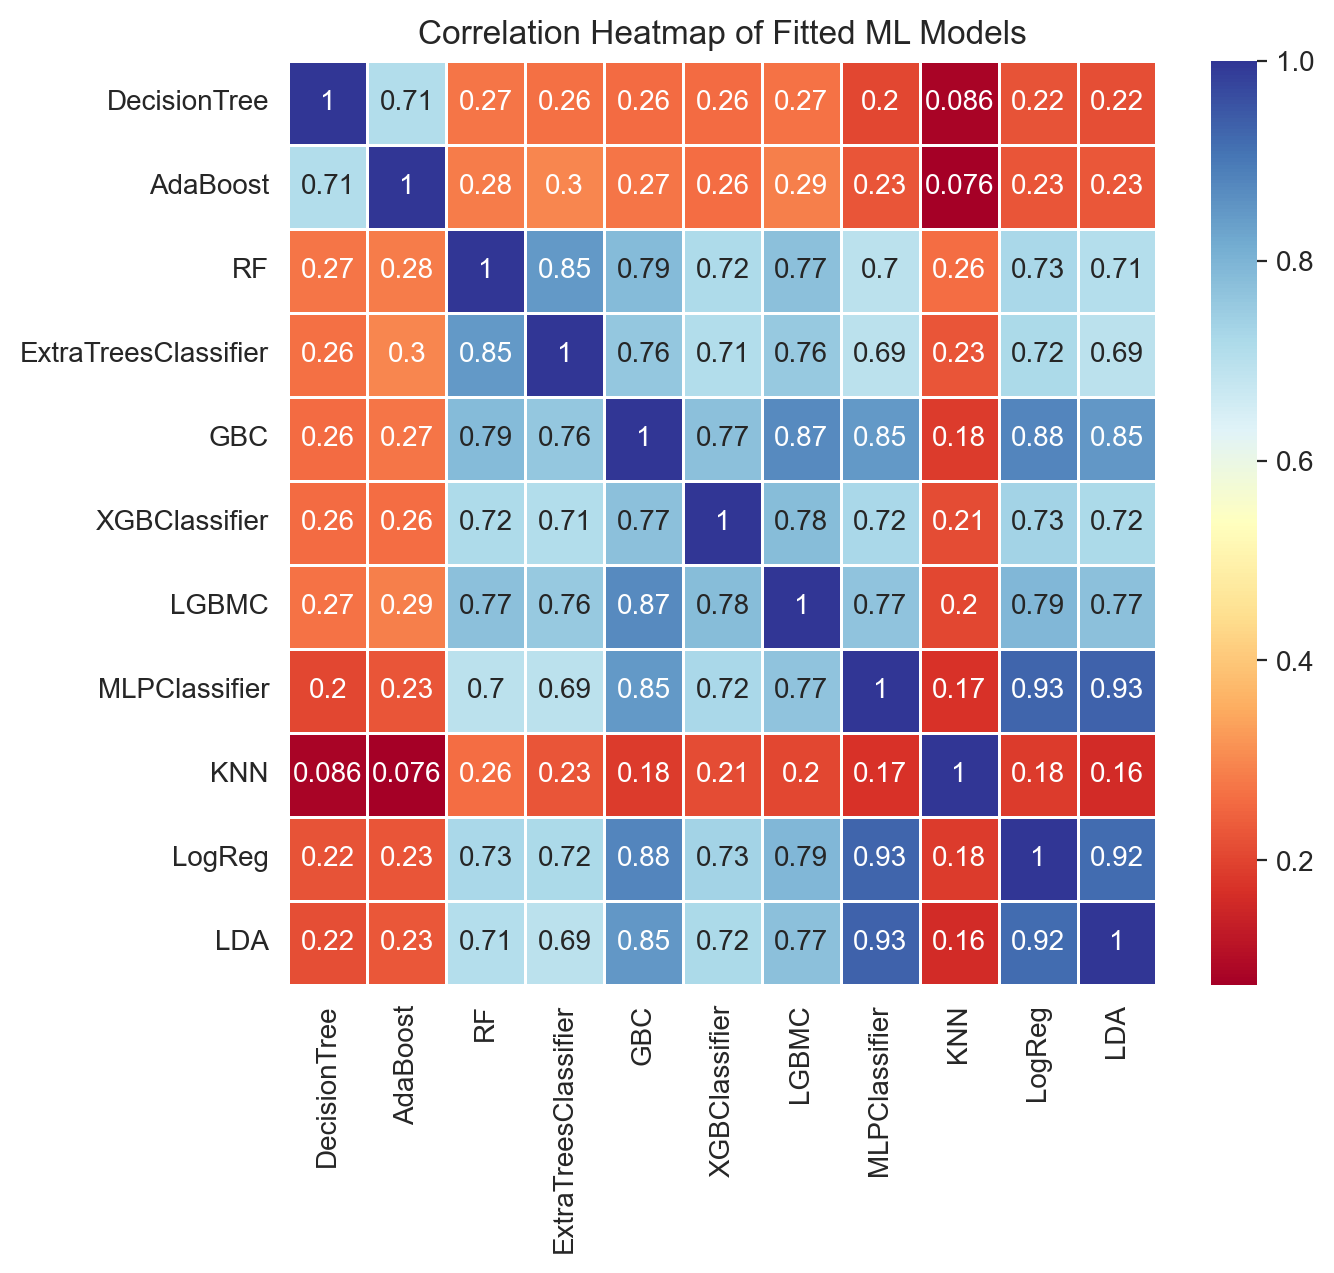

In [50]:
# Calculate the correlation matrix
corr_matrix = predictions_df.corr()

plt.figure(figsize=(7, 6))
sns.heatmap(corr_matrix, annot=True, cmap="RdYlBu", linewidths=0.5)
plt.title('Correlation Heatmap of Fitted ML Models')
plt.show()

In [51]:
gb = GradientBoostingClassifier(random_state=random_state)
gb.fit(encoded_X_train, encoded_y_train)
n_scores = cross_val_score(gb, encoded_X_train, encoded_y_train, scoring='roc_auc', cv=kfold, n_jobs=-1, verbose=3, error_score='raise')
print(f'ROC-AUC is {np.mean(n_scores)} ± {np.std(n_scores)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.2s remaining:    4.9s


ROC-AUC is 0.6721471179902418 ± 0.0075506492395214


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished


In [52]:
mlpc = MLPClassifier(random_state=random_state)
mlpc.fit(encoded_X_train, encoded_y_train)
n_scores = cross_val_score(mlpc, encoded_X_train, encoded_y_train, scoring='roc_auc', cv=kfold, n_jobs=-1, verbose=3, error_score='raise')
print(f'ROC-AUC is {np.mean(n_scores)} ± {np.std(n_scores)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.3s


ROC-AUC is 0.6641217885191057 ± 0.009804724870229665


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


In [53]:
logreg = LogisticRegression(random_state=random_state)
logreg.fit(encoded_X_train, encoded_y_train)
n_scores = cross_val_score(logreg, encoded_X_train, encoded_y_train, scoring='roc_auc', cv=kfold, n_jobs=-1, verbose=3, error_score='raise')
print(f'ROC-AUC is {np.mean(n_scores)} ± {np.std(n_scores)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s


ROC-AUC is 0.6601048150497 ± 0.007929008411186909


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


# Tuning models

In [54]:
n_iter = 350

In [55]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

random_search = RandomizedSearchCV(gb, param_distributions=param_grid, n_iter=n_iter/5, scoring='roc_auc', cv=3, n_jobs=-1, verbose=3, error_score='raise')
random_search.fit(encoded_X_train, encoded_y_train)

print("Best Parameters: ", random_search.best_params_)

Fitting 3 folds for each of 70 candidates, totalling 210 fits
Best Parameters:  {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.01}


In [56]:
best_gb = GradientBoostingClassifier(random_state=random_state, **random_search.best_params_)
best_gb.fit(encoded_X_train, encoded_y_train)
n_scores = cross_val_score(best_gb, encoded_X_train, encoded_y_train, scoring='roc_auc', cv=kfold, n_jobs=-1, verbose=3, error_score='raise')
print(f'ROC-AUC is {np.mean(n_scores)} ± {np.std(n_scores)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.7s remaining:   17.7s


ROC-AUC is 0.6817512762967144 ± 0.0060553670039311565


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.9s finished


In [57]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['logistic', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': [0.0001, 0.001, 0.01],
}

random_search = RandomizedSearchCV(mlpc, param_distributions=param_grid, n_iter=n_iter, scoring='roc_auc', cv=3, n_jobs=-1, verbose=3, error_score='raise')
random_search.fit(encoded_X_train, encoded_y_train)

print("Best Parameters: ", random_search.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best Parameters:  {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 100), 'alpha': 0.001, 'activation': 'relu'}


In [58]:
best_mlpc = MLPClassifier(random_state=random_state, **random_search.best_params_)
best_mlpc.fit(encoded_X_train, encoded_y_train)
n_scores = cross_val_score(best_mlpc, encoded_X_train, encoded_y_train, scoring='roc_auc', cv=kfold, n_jobs=-1, verbose=3, error_score='raise')
print(f'ROC-AUC is {np.mean(n_scores)} ± {np.std(n_scores)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.7s


ROC-AUC is 0.6689771184554744 ± 0.0033924601520832903


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.1s finished


In [59]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

random_search = RandomizedSearchCV(logreg, param_distributions=param_grid, n_iter=n_iter, scoring='roc_auc', cv=3, n_jobs=-1, verbose=3, error_score='raise')
random_search.fit(encoded_X_train, encoded_y_train)

print("Best Parameters: ", random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters:  {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}


In [60]:
best_logreg = LogisticRegression(random_state=random_state, **random_search.best_params_)
best_logreg.fit(encoded_X_train, encoded_y_train)
n_scores = cross_val_score(best_logreg, encoded_X_train, encoded_y_train, scoring='roc_auc', cv=kfold, n_jobs=-1, verbose=3, error_score='raise')
print(f'ROC-AUC is {np.mean(n_scores)} ± {np.std(n_scores)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s


ROC-AUC is 0.6802461472437591 ± 0.004568478506975349


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


In [61]:
def calc_roc_auc_on_validation_set(model):
    y_pred = model.predict_proba(encoded_X_val)[:, 1]
    return roc_auc_score(y_val, y_pred)

In [62]:
gb = GradientBoostingClassifier(random_state=random_state)
gb.fit(encoded_X_train, encoded_y_train)
mlpc = MLPClassifier(random_state=random_state)
mlpc.fit(encoded_X_train, encoded_y_train)
logreg = LogisticRegression(random_state=random_state)
logreg.fit(encoded_X_train, encoded_y_train)

LogisticRegression(random_state=2)

In [63]:
print(calc_roc_auc_on_validation_set(gb))
print(calc_roc_auc_on_validation_set(best_gb))

0.6541484362339978
0.6387538486468967


In [64]:
print(calc_roc_auc_on_validation_set(mlpc))
print(calc_roc_auc_on_validation_set(best_mlpc))

0.636181332036947
0.6542092043428942


In [65]:
print(calc_roc_auc_on_validation_set(logreg))
print(calc_roc_auc_on_validation_set(best_logreg))

0.6446888672824502
0.6519202722411279


In [66]:
ensemble_model = VotingClassifier(estimators=[
    ('gb', gb),
    ('mlpc', best_mlpc),
    ('logreg', best_logreg),
        ],
    voting='soft')

ensemble_model.fit(encoded_X_full, encoded_y_full)

VotingClassifier(estimators=[('gb', GradientBoostingClassifier(random_state=2)),
                             ('mlpc',
                              MLPClassifier(alpha=0.001,
                                            hidden_layer_sizes=(100, 100),
                                            random_state=2)),
                             ('logreg',
                              LogisticRegression(C=0.1, penalty='l1',
                                                 random_state=2,
                                                 solver='liblinear'))],
                 voting='soft')

In [67]:
n_scores = cross_val_score(ensemble_model, encoded_X_full, encoded_y_full, scoring='roc_auc', cv=kfold, n_jobs=-1, verbose=3, error_score='raise')
print(f'ROC-AUC is {np.mean(n_scores)} ± {np.std(n_scores)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.3s remaining:   16.9s


ROC-AUC is 0.68684901307895 ± 0.011497280972821447


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s finished


In [68]:
print(calc_roc_auc_on_validation_set(ensemble_model))

0.7107032895802949


In [69]:
user_id = X_test.index

y_test = ensemble_model.predict_proba(encoded_X_test)[:, 1]

predicted_df = pd.DataFrame(y_test, index=user_id, columns=['target'])
predicted_df['Predictions'] = np.where(predicted_df['target'] > 0.5, 'Republican', 'Democrat')
predicted_df = predicted_df.drop('target', axis=1)

In [71]:
predicted_df.head(25)

,Predictions
USER_ID,
2,Democrat
3,Republican
6,Republican
7,Democrat
14,Democrat
28,Republican
29,Democrat
37,Republican
44,Democrat


In [72]:
# Write to CSV
predicted_df.to_csv('out_4.csv')